## 🏥 HealthMate-AI: A Retrieval-Augmented Generation Medical Chatbot for Accessible Health Information
**Authors:** Yogvid Wankhede & Leonardo Nan  

This project implements a Retrieval-Augmented Generation (RAG) chatbot that delivers reliable, grounded medical information by combining large language models (LLMs) with a curated knowledge base. The system constructs vector embeddings from trusted medical texts (e.g., *The Gale Encyclopedia of Medicine*), stores them in a Pinecone database, retrieves contextually relevant information for each user query, and generates responses using an LLM such as LLaMA or GPT. This approach minimizes hallucination and ensures factual accuracy while improving accessibility and trustworthiness in AI-assisted health communication.


### 🔹 Code Section
#### Data loading

In [1]:
from data_saving import load_pdf_files
# clear_pdf_cache()  # Deletes old cache
extracted_data = load_pdf_files("data")

📦 Loading from cache: pdf_cache.pkl
⏱️  This should be instant!

✅ Successfully loaded 4505 documents from cache
📁 Cache file size: 17.70 MB



In [2]:
extracted_data[:5]

[Document(metadata={'producer': 'PDFlib+PDI 6.0.3 (SunOS)', 'creator': 'Adobe Acrobat 6.0', 'creationdate': '2006-10-16T20:19:33+02:00', 'moddate': '2006-10-16T22:03:45+02:00', 'source': 'data\\The Gale Encyclopedia.pdf', 'total_pages': 4505, 'page': 0, 'page_label': 'i'}, page_content=''),
 Document(metadata={'producer': 'PDFlib+PDI 6.0.3 (SunOS)', 'creator': 'Adobe Acrobat 6.0', 'creationdate': '2006-10-16T20:19:33+02:00', 'moddate': '2006-10-16T22:03:45+02:00', 'source': 'data\\The Gale Encyclopedia.pdf', 'total_pages': 4505, 'page': 1, 'page_label': 'ii'}, page_content='The GALE\nENCYCLOPEDIA of\nMEDICINE\nTHIRD EDITION'),
 Document(metadata={'producer': 'PDFlib+PDI 6.0.3 (SunOS)', 'creator': 'Adobe Acrobat 6.0', 'creationdate': '2006-10-16T20:19:33+02:00', 'moddate': '2006-10-16T22:03:45+02:00', 'source': 'data\\The Gale Encyclopedia.pdf', 'total_pages': 4505, 'page': 2, 'page_label': 'iii-1'}, page_content='The GALE\nENCYCLOPEDIA of\nMEDICINE\nTHIRD EDITION\nVOLUME\n\x81\n1\nA-B\

In [4]:
len(extracted_data)

4505

#### Data Cleaning

In [5]:
# Filtering the data as we only need the source and page content

from typing import List
from langchain.schema import Document

def filter_to_minimal_docs(docs: List[Document]) -> List[Document]:
    """
    Given a list of Document objects, return a new list of Document objects
    containing only 'source' in metadata and the original page_content.
    """
    minimal_docs: List[Document] = []
    for doc in docs:
        src = doc.metadata.get("source")
        minimal_docs.append(
            Document(
                page_content=doc.page_content,
                metadata={"source": src}
            )
        )
    return minimal_docs

In [6]:
minimal_docs = filter_to_minimal_docs(extracted_data)

In [7]:
# cleaned data
minimal_docs[:5]

[Document(metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content=''),
 Document(metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content='The GALE\nENCYCLOPEDIA of\nMEDICINE\nTHIRD EDITION'),
 Document(metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content='The GALE\nENCYCLOPEDIA of\nMEDICINE\nTHIRD EDITION\nVOLUME\n\x81\n1\nA-B\nJACQUELINE L. LONGE, PROJECT EDITOR'),
 Document(metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content='The GALE\nENCYCLOPEDIA of\nMEDICINE\nTHIRD EDITION\nVOLUME\n\x81\n2\nC-F\nJACQUELINE L. LONGE, PROJECT EDITOR'),
 Document(metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content='The GALE\nENCYCLOPEDIA of\nMEDICINE\nTHIRD EDITION\nVOLUME\n\x81\n3\nG-M\nJACQUELINE L. LONGE, PROJECT EDITOR')]

#### Chunking

In [8]:
# Split the documents into smaller chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

def text_split(minimal_docs):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=20,
    )
    texts_chunk = text_splitter.split_documents(minimal_docs)
    return texts_chunk

In [9]:
texts_chunk = text_split(minimal_docs)
print(f"Number of chunks: {len(texts_chunk)}")

Number of chunks: 40000


In [10]:
texts_chunk[:5]

[Document(metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content='The GALE\nENCYCLOPEDIA of\nMEDICINE\nTHIRD EDITION'),
 Document(metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content='The GALE\nENCYCLOPEDIA of\nMEDICINE\nTHIRD EDITION\nVOLUME\n\x81\n1\nA-B\nJACQUELINE L. LONGE, PROJECT EDITOR'),
 Document(metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content='The GALE\nENCYCLOPEDIA of\nMEDICINE\nTHIRD EDITION\nVOLUME\n\x81\n2\nC-F\nJACQUELINE L. LONGE, PROJECT EDITOR'),
 Document(metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content='The GALE\nENCYCLOPEDIA of\nMEDICINE\nTHIRD EDITION\nVOLUME\n\x81\n3\nG-M\nJACQUELINE L. LONGE, PROJECT EDITOR'),
 Document(metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content='The GALE\nENCYCLOPEDIA of\nMEDICINE\nTHIRD EDITION\nVOLUME\n\x81\n4\nN-S\nJACQUELINE L. LONGE, PROJECT EDITOR')]

#### Embedding

In [11]:
#Using Model from HuggimngFace for Embedding
#Model for turning text-vector form

from langchain.embeddings import HuggingFaceEmbeddings
# from embeddings import CustomEnsembleEmbeddings
def download_embeddings():
    """
    Download and return the HuggingFace embeddings model.
    """

    # embeddings = CustomEnsembleEmbeddings(
    #     model_path="D:/1A Medical Projecy/l6v2_3fold_models/l6v2_3fold_ensemble"
    # )
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
    embeddings = HuggingFaceEmbeddings(
        model_name=model_name
    )
    return embeddings

embedding = download_embeddings()

C:\Users\Asus\AppData\Local\Temp\ipykernel_24424\2098477131.py:15: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
embedding

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [13]:
# Testing loaded embedding method

vector = embedding.embed_query("Hey")
vector[:10]

[-0.1142386645078659,
 0.013737412169575691,
 0.05483824759721756,
 0.026122070848941803,
 0.03366685286164284,
 -0.08073431998491287,
 0.12946352362632751,
 0.033052634447813034,
 -0.029046379029750824,
 -0.04729180783033371]

In [14]:
print( "Vector length:", len(vector)) # Dimension of the embeddings

Vector length: 384


#### API and Database Connection

In [15]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [16]:
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")


os.environ["PINECONE_API_KEY"] = PINECONE_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

#### Pinecone Database

In [17]:
from pinecone import Pinecone 
pinecone_api_key = PINECONE_API_KEY

check = Pinecone(api_key=pinecone_api_key)

In [18]:
check

Loading Pinecone Data

In [19]:
# Creating and calling Database: Pinecone Database
from pinecone import ServerlessSpec 

index_name = "healthmate-ai"
# index_name = "med-chunks"

if not check.has_index(index_name):
    check.create_index(
        name = index_name,
        dimension=384,  # Dimension of the embeddings
        metric= "cosine",  # Cosine similarity
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )


index = check.Index(index_name)

In [ ]:
# Storing Vectors in Pinecone

from langchain_pinecone import PineconeVectorStore

docsearch = PineconeVectorStore.from_documents(
    documents=texts_chunk,
    embedding=embedding,
    index_name=index_name
)

In [20]:
# Load Existing Index from Pinecone 

from langchain_pinecone import PineconeVectorStore

# Embed each chunk and upsert the embeddings into your Pinecone index.
docsearch = PineconeVectorStore.from_existing_index(
    index_name=index_name,
    embedding=embedding
)

In [20]:
# Add more data to the existing Pinecone index (Custom Data)

dswith = Document(
    page_content="Hello my name is Yogvid Wankhede",
    metadata={"source": "Desktop"}
)

# Will provide Uniques ID to search in pinecone to see whether the index is added
docsearch.add_documents(documents=[dswith]) 

['eb89f9db-551e-469b-8c01-d803f6a3aa3c']

#### Similarity Check

In [21]:
#Returns k number of results from knowledge base

retriever = docsearch.as_retriever(search_type="similarity", search_kwargs={"k":3})

In [22]:
retrieved_docs = retriever.invoke("What is headache?")
retrieved_docs

[Document(id='9fc0da74-c4b1-424b-b067-5ae0b7664f74', metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content='Headache\nDefinition\nA headache involvespain in the head which can\narise from many disorders or may be a disorder in and\nof itself.\nDescription\nThere are three types of primary headaches:\ntension-type (muscular contraction headache),\nmigraine (vascular headaches), and cluster. Virtually\neveryone experiences a tension-type headache at some\npoint. An estimated 18% of American women suffer\nmigraines, compared to 6% of men. Cluster headaches\naffect fewer than 0.5% of the population, and men'),
 Document(id='d1a8c35f-00ba-444c-af70-60eb922e15b5', metadata={'source': 'data\\The Gale Encyclopedia.pdf'}, page_content='ling). Pain-sensitive structures in the head include\nblood vessel walls, membranous coverings of the\nbrain, and scalp and neck muscles. Brain tissue itself\nhas no sensitivity to pain. Therefore, headaches may\nresult from contraction of the musc

#### LLM

In [23]:
from langchain_openai import ChatOpenAI

# Mistral-7B-instruct
chatModel = ChatOpenAI(model="gpt-4o")

In [24]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

LLM Setup

In [25]:
system_prompt = (
    "You are a trusted Medical Assistant designed for question-answering tasks. "
    "Rely strictly on the provided context to generate your response. "
    "Provide answers in no more than three sentences, keeping them accurate, concise, and easy to understand."
    "\n\n"
    "{context}"
)


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

Combining LLM with RAG Chain

In [26]:
question_answer_chain = create_stuff_documents_chain(chatModel, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

#### Examples

In [27]:
# Custom data test

response = rag_chain.invoke({"input": "What is my name?"})
print(response["answer"])

Your name is Yogvid Wankhede.


In [28]:
response = rag_chain.invoke({"input": "What is Cancer?"})
print(response["answer"])

Cancer is a large group of nearly 100 diseases characterized by uncontrolled cell growth and the ability of these cells to migrate and spread to distant sites in the body. If not controlled, it can lead to death. It is a disease of the genes, involving the abnormal growth and spread of cancerous cells.


In [29]:
response = rag_chain.invoke({"input": "what is headache?"})
print(response["answer"])

A headache involves pain in the head, which can arise from numerous disorders or be a disorder itself. It can be caused by various factors, including muscle contractions, blood vessel dilation, or specific nerve involvement. There are three primary types: tension-type headaches, migraines, and cluster headaches.


#### Visualizations and Results


✅ EVALUATION RESULTS FOUND!
📂 Loading from: evaluation_results/evaluation_results_LATEST.csv

✓ Loaded 535 evaluation results
📊 Displaying report and visualizations...

📂 Loading latest results: evaluation_results/evaluation_results_LATEST.csv


HEALTHMATE-AI EVALUATION REPORT (from saved data)

Total Questions: 535

----------------------------------------------------------------------
METRIC SUMMARY
----------------------------------------------------------------------

BLEU Score:
  Average:  0.3377
  Min:      0.0526
  Max:      0.9231

ROUGE-L Score:
  Average:  0.2628
  Min:      0.0345
  Max:      0.6479

Overall Maximum Score: 0.3415

----------------------------------------------------------------------
PASSING CRITERIA
----------------------------------------------------------------------
BLEU ≥ 0.50:    ✗ FAIL
ROUGE-L ≥ 0.50: ✗ FAIL

----------------------------------------------------------------------
TOP 5 BEST PERFORMING
-------------------------------------------------

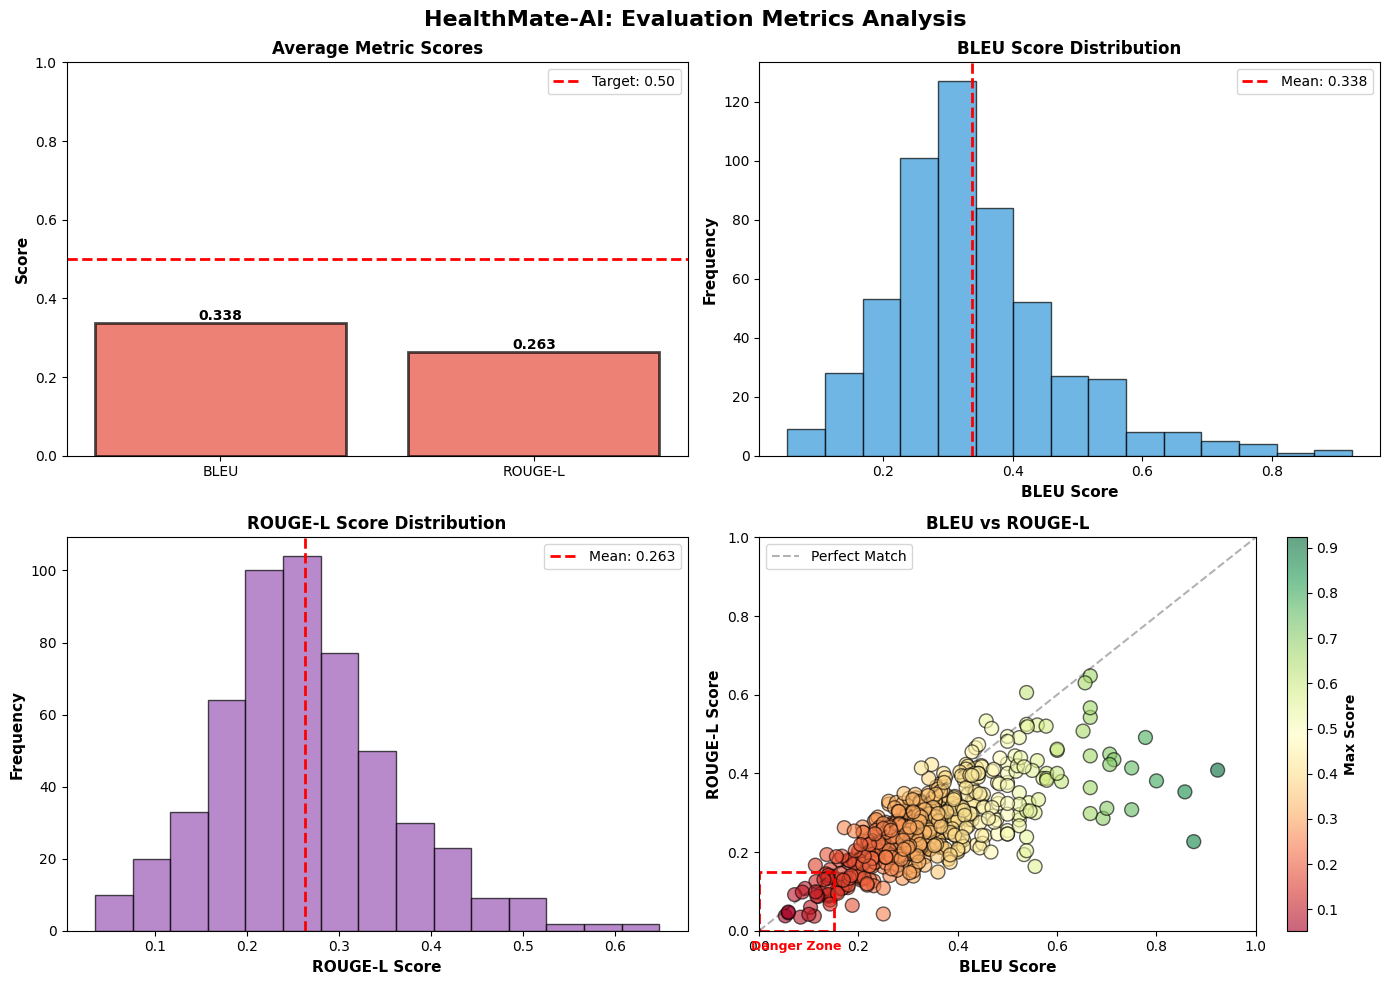

📊 Creating Box and Whiskers Plot from saved data...

📂 Loading latest results: evaluation_results/evaluation_results_LATEST.csv

✅ Saved: evaluation_box_whiskers.png



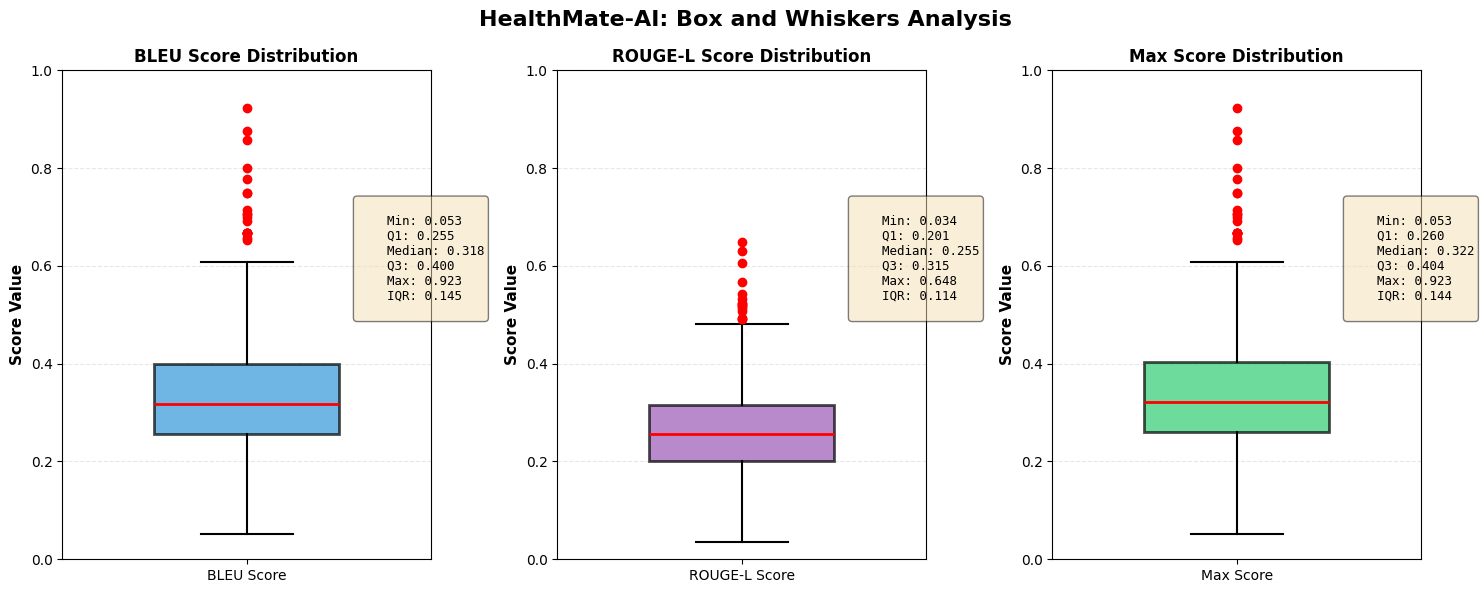

In [ ]:
# Saving Results and files
from eval_metrices import main_evaluation, quick_visualize_all

results_df = main_evaluation(
    csv_path='data/new_medical_questions.csv',
    rag_chain=rag_chain,
    retriever=retriever,
    encoding='macroman',
)

In [ ]:
# # Loading Results!
# results_df = main_evaluation()

# quick_visualize_all()